# Variational Autoencoder (VAE) for real-valued input data

This notebook contains the class definition of a VAE with two hidden layers in the encoder and decoder. The layer sizes and the dimension of the model can be chosen freely. The model is defined for real-valued input data and uses a sigmoid output layer.

For details on the individual aspects, look at the other notebook. The functionality of this model is exactly the same as before. However, I tried to improve the implementation:

- To structure the class I looked at existing TensorFlow models and a [post](https://blog.metaflow.fr/tensorflow-a-proposal-of-good-practices-for-files-folders-and-models-architecture-f23171501ae3) on good practices for model architectures
- I used tf.layers.dense to avoid initializing weights and biases manually
- I used the Xavier initializer provided by tf.contrib
- The model is saved and can be restored
- The implementation includes tensorboard to aid debugging and visalization

In [4]:
% matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import the MNIST Data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Class definition

In [5]:
class variational_autoencoder:
    
    def __init__(self, config):
        self.config = config
        self.initializer = tf.contrib.layers.xavier_initializer()
        self.activation_fct = self.config['activation_fct']
        self.random_seed = self.config['random_seed']
        self.learning_rate = self.config['learning_rate']      
        
        self.sess = tf.InteractiveSession()
        self.build_graph()
        
    def _create_placeholders(self):
        """
        Creates placeholder for the input data
        """
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, shape=[None, self.config['n_input']])
            
                
    def _create_encoder(self):    
        """
        Computes the output of the encoder network for a given input vector
        
        The encoder network is used to approximate the true posterior p(z|x)
        using the variational distribution q_phi(z|x). Usually, q_phi(z|x) is
        taken to be a Gaussian distribution with a diagonal covariance matrix
        whose mean and variance vectors are parametrized by a neural network
        with input x.
        So the encoder network takes x as an input and produces a vector of 
        means and a vector of variances (or more precise a vector of log squared variances) 
        of a Gaussian distribution. From this we can sample values of z, i.e. z ~ q_phi(z|x)
        """
        with tf.name_scope("encoder"):
            
            layer1 = tf.layers.dense(self.data, self.config['h1_encoder'], activation=self.activation_fct, kernel_initializer=self.initializer)
            layer2 = tf.layers.dense(layer1, self.config['h2_encoder'], activation=self.activation_fct, kernel_initializer=self.initializer)
            means = tf.layers.dense(layer2, self.config['n_latent'], activation=None, kernel_initializer=self.initializer)
            log_sigmas_sq = tf.layers.dense(layer2, self.config['n_latent'], activation=None, kernel_initializer=self.initializer)

            # Vector of means
            self.encoder_mean = means
            # Vector of log squared variances
            self.encoder_loq_sigma_sq = log_sigmas_sq

    def _create_decoder(self):      
        """
        Computes the output of the decoder network (i.e. the reconstruction) for some latent vector z.
        The latent vector is sampled from the encoder using the reparametrization trick.
        The decoder network takes a latent variable z as an input and reproduces the input x. 
        """
        with tf.name_scope("decoder"):
            # Reparametrization trick
            eps = tf.random_normal(tf.shape(self.encoder_loq_sigma_sq), dtype=tf.float32)
            self.z = self.encoder_mean + tf.sqrt(tf.exp(self.encoder_loq_sigma_sq)) * eps
            # Layer activations
            layer1 = tf.layers.dense(self.z, self.config['h1_decoder'], activation=self.activation_fct, kernel_initializer=self.initializer)
            layer2 = tf.layers.dense(layer1, self.config['h2_decoder'], activation=self.activation_fct, kernel_initializer=self.initializer)
            # Reconstruction                       
            self.logits = tf.layers.dense(layer2, self.config['n_input'])   
            self.reconstr = tf.sigmoid(self.logits)
            
    def _create_loss(self):
        """
        Computes the loss of the network. The loss function has two terms
        1) The reconstruction loss: -log(p(x|z)) which rewards a good reconstruction

        2) The latent loss: Kullback-Leibler divergence between q_phi(z|x) and the prior
        p(z) (which is given by a standard normal distribution).
        This loss acts as a regularizer because it penalizes q_phi(z|x) for
        deviating from a standard normal distribution.
        """
        with tf.name_scope("loss"):
            with tf.name_scope("latent_loss"):             
                self.latent_loss = -0.5*tf.reduce_sum(1 + self.encoder_loq_sigma_sq
                                             - tf.square(self.encoder_mean) 
                                             - tf.exp(self.encoder_loq_sigma_sq))

            with tf.name_scope("reconstruction_loss"):
                self.reconstr_loss = tf.reduce_sum(
                    tf.nn.sigmoid_cross_entropy_with_logits(labels=self.data, logits=self.logits))

            
            self.loss = self.latent_loss + self.reconstr_loss
        
    def _create_optimizer(self):
        """
        Minimizes the loss using an Adam optimizer
        """
        with tf.name_scope("optimizer"):
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

    def _create_summaries(self):
        """
        Adds summaries for visualization in TensorBoard
        """
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)    
            tf.summary.scalar("latent_loss", self.latent_loss)
            tf.summary.scalar("reconstruction_loss", self.reconstr_loss)
            self.summary_op = tf.summary.merge_all()
            
    def build_graph(self):
        """
        Creates the VAE network by creating placeholders and setting up the 
        encoder and decoder network, the loss, the optimizer, summaries for
        tensorboard and initializing all variables.
        """
        print("Creating placeholders...")
        self._create_placeholders()
        print("Create encoder...")
        self._create_encoder()
        print("Create decoder...")
        self._create_decoder()
        print("Create loss...")
        self._create_loss()
        print("Create optimizer...")
        self._create_optimizer()
        print("Create summaries...")
        self._create_summaries()
        print("Initializing all variables...")
        with tf.name_scope("init_variables"):
            self.sess.run(tf.global_variables_initializer())
        
        
    def batch_fit(self, input_data): 
        """
        Trains the model on a given batch of input data.
        """
        with tf.name_scope("batch_fit"):
            self.sess.run(self.optimizer, {self.data:input_data})
            return self
            
    def get_loss(self, input_data):
        """
        Returns the loss of the model
        """
        with tf.name_scope("get_loss"):
            return self.sess.run(self.loss, {self.data:input_data})
    
    def reconstruct(self, input_data):
        """
        Reconstructs a given batch of input data
        """
        with tf.name_scope("reconstruct_data"):
            return self.sess.run(self.reconstr, {self.data:input_data})
    
    def generate(self, batch_size):
        """
        Generates new data by sampling from the latent dimension and running the decoder
        """
        with tf.name_scope('generate_data'):
            z = np.random.normal(size=(batch_size, self.config['n_latent']))

            new_data = self.sess.run(self.reconstr, {self.z: z})
            return new_data

## Model initalization

In [6]:
tf.reset_default_graph()

n_epochs = 40
batch_size = 128
display_step = 5

net_architecture = dict(
    
    n_input = 784,
    
    h1_encoder = 500,
    h2_encoder = 500,
    
    h1_decoder = 500,
    h2_decoder = 500,
    
    n_latent = 20,    
    
    activation_fct = tf.nn.elu, #tf.nn.softplus,
    learning_rate = 0.001,
    random_seed = 123
)


model = variational_autoencoder(net_architecture)

Creating placeholders...
Create encoder...
Create decoder...
Create loss...
Create optimizer...
Create summaries...
Initializing all variables...


## Training

In [7]:
# We create a string with the current data and time to get a unique
# log-directory every time the model is run
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "/tmp/tensorboard"
result_dir = "{}/run-{}".format(root_logdir, now)

print("TensorBoard log directory: ", result_dir)

# Add a writer for tensorboard
writer = tf.summary.FileWriter(result_dir, model.sess.graph)
saver = tf.train.Saver()

tf.set_random_seed(model.random_seed)

for epoch in range(n_epochs):
    n_batches = int(mnist.train.num_examples/batch_size)
    
    for i in range(n_batches):

        batch_x, _ = mnist.train.next_batch(batch_size)
        # Fit the model on the current batch
        model.batch_fit(batch_x)
        # Compute the loss and add summaries
        loss, logits, latent_l, reconstr_l, summary = model.sess.run([model.loss, model.logits, model.latent_loss,
                                                                      model.reconstr_loss, model.summary_op],
                                                                     {model.data: batch_x})
        #loss, summary = model.sess.run([model.loss, model.summary_op], {model.data: batch_x})
        writer.add_summary(summary, i)
      
    # Save the current model
    save_path = saver.save(model.sess, "/tmp/my_model.ckpt")
    print("Epoch: ", epoch, "| Loss: ", loss, "| Latent loss: ", latent_l, "| Reconstr. loss: ", reconstr_l)

# Save the final model 
save_path = saver.save(model.sess, "/tmp/my_model_final.ckpt")    
writer.close()

TensorBoard log directory:  /tmp/tensorboard/run-20170620125133
Epoch:  0 | Loss:  14915.1 | Latent loss:  2850.59 | Reconstr. loss:  12064.6
Epoch:  1 | Loss:  14210.7 | Latent loss:  3032.94 | Reconstr. loss:  11177.8
Epoch:  2 | Loss:  13975.1 | Latent loss:  3055.83 | Reconstr. loss:  10919.3
Epoch:  3 | Loss:  13503.8 | Latent loss:  3108.58 | Reconstr. loss:  10395.2
Epoch:  4 | Loss:  13885.2 | Latent loss:  3189.24 | Reconstr. loss:  10696.0
Epoch:  5 | Loss:  13676.9 | Latent loss:  3204.29 | Reconstr. loss:  10472.6
Epoch:  6 | Loss:  13682.8 | Latent loss:  3172.06 | Reconstr. loss:  10510.8
Epoch:  7 | Loss:  13881.0 | Latent loss:  3262.33 | Reconstr. loss:  10618.7
Epoch:  8 | Loss:  13282.7 | Latent loss:  3144.47 | Reconstr. loss:  10138.2
Epoch:  9 | Loss:  13386.8 | Latent loss:  3222.39 | Reconstr. loss:  10164.4
Epoch:  10 | Loss:  13063.7 | Latent loss:  3072.59 | Reconstr. loss:  9991.07
Epoch:  11 | Loss:  12977.5 | Latent loss:  3070.71 | Reconstr. loss:  9906.7

## Reconstruction

To test the reconstruction capability of the model we visualize 5 original MNIST digits and their reconstructions.

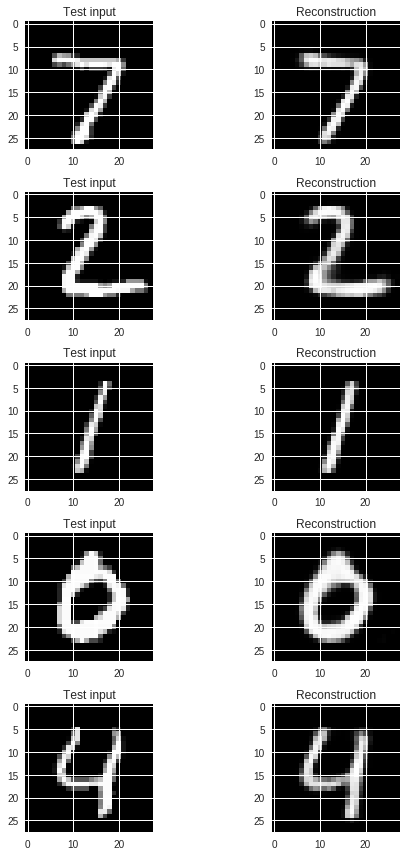

In [8]:
x_sample, _ = mnist.test.next_batch(batch_size)
x_reconstruct = model.reconstruct(x_sample)

fig = plt.figure(figsize=(8,12))
for i in range(5):
    ax1 = fig.add_subplot(5,2,2*i+1)
    ax1.set_title("Test input")
    ax1.imshow(x_sample[i].reshape(28,28), cmap='gray')
    
    ax2 = fig.add_subplot(5,2,2*i+2)
    ax2.set_title("Reconstruction")
    ax2.imshow(x_reconstruct[i].reshape(28,28), cmap='gray')
    
plt.tight_layout()

## Generating new data

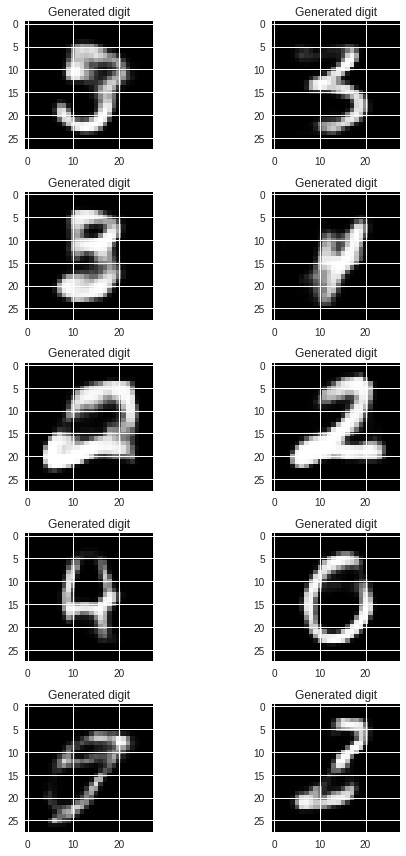

In [9]:
new_data = model.generate(batch_size)

fig = plt.figure(figsize=(8,12))

for i in range(10):
    ax = fig.add_subplot(5,2,i+1)
    ax.imshow(new_data[i].reshape(28,28), cmap='gray')
    ax.set_title("Generated digit")

plt.tight_layout()

## Restoring and testing a saved model

To restore a saved model run all code up to the training part. When initializing the model be careful to use the same layer sizes as in the model you want to restore.

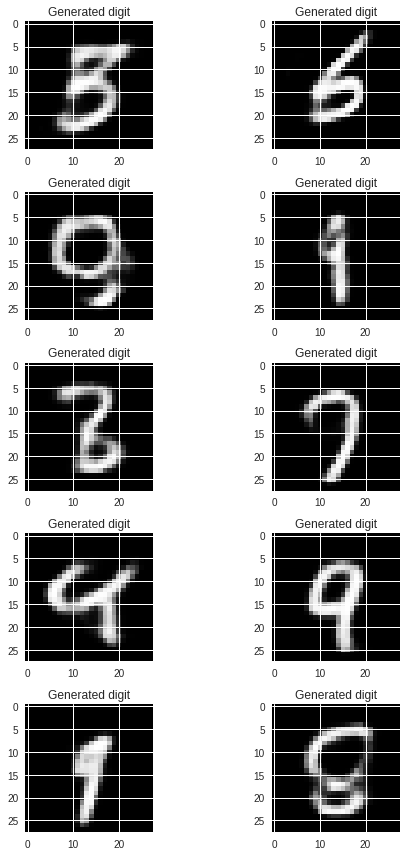

In [12]:
saver = tf.train.Saver()
with tf.Session() as sess:

    # Restore model weights from previously saved model
    saver.restore(model.sess, '/tmp/my_model_final.ckpt')
    #saver.restore(model.sess, '/home/anna-lena/dllibrary/code/saved_models/500_500_100_final.ckpt')
    
    new_data = model.generate(batch_size)

    fig = plt.figure(figsize=(8,12))

    for i in range(10):
        ax = fig.add_subplot(5,2,i+1)
        ax.imshow(new_data[i].reshape(28,28), cmap='gray')
        ax.set_title("Generated digit")

    plt.tight_layout()